# Ignorar

# Tabla de contenidos

- [1 - Librerías](#lib)
- [2 - Paths para Proyecto](#path)
- [3 - Análisis de Datos Exploratorios (EDA)](#eda)
- [4 - Data Augmentation](#aug)
- [5 - Metadata](#meta)
- [6 - Carga de imágenes y metadata](#carga)
- [7 - Creación de DataBlock](#db)
- [8 - Función de Accuracy: ATSIA_ACC](#acc_atsia)
- [9 - Función de Pérdida: Binary Cross-Entropy with Logits Loss](#loss_fun)
- [10 - Modelo](#model)
- [11 - Métricas](#metrics)
- [12 - Resutados](#results)
- [13 - Widget Prueba](#widget)

<a name='lib'></a>
## Librerías

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from utils_ATSIA import *

import os
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

<a name='path'></a>
## Paths para proyecto

In [2]:
organos = ["AmpollaRectal", "Branquias", "Hepatopancreas", "Intestino", "Uropodo"]
grados = ["G0", "G1", "G2", "G3", "G4"]
caracteristicas = {"AmpollaRectal" :["GG", "N"], #"Gregarinas Gametocistos, Nemátodos"
                   "Branquias" : ["S", "M", "N", "P", "AF"],# "Suciedad, Melanización, Necrosis, Protozoarios y Algas Filamentosas"
                   "Hepatopancreas" : ["DC", "DT", "L", "M", "N"], #"Deformidad Celular, Desprendimiento Tubular, Lípidos, Melanización y Necrosis"
                   "Intestino" : ["GT", "GG", "N", "A", "RC"], #"Gregarinas Trofozoito, Gregarina Gametocistos, Nemátodos, Algas y Restos de Crustaceos"
                   "Uropodo" : ["Prem", "Muda", "Post", "Inte"]}

#Necesitamos la cantidad de caracteres que cada nomenclatura tiene para cada órgano
organo_len = {"AmpollaRectal" : 10, "Branquias" : 25, "Hepatopancreas" : 26, "Intestino" : 27, "Uropodo" :4}

In [3]:
main_path = Path(os.getcwd()) #Cuando estemos en local
Path.BASE_PATH = main_path
# main_path = "/content/drive/MyDrive/ATSIA" #Cuando usamos Google Drive
path = {}
path["data"] = {}
path["img"] = {}
path["metadata"] = {}

for organo in organos: 
    if not os.path.exists(Path(os.path.join("data", organo))):
        os.mkdir(Path(os.path.join("data", organo)))
    if not os.path.exists(Path(os.path.join("img", organo))):
        os.mkdir(Path(os.path.join("img", organo)))
    if not os.path.exists(Path(os.path.join("metadata", organo))):
        os.mkdir(Path(os.path.join("metadata", organo)))

for organo in organos:
    path["data"][organo] = Path(os.path.join("data", organo, f"X_{organo}.npy"))
    path["img"][organo] = Path(os.path.join("img", organo))
    path["metadata"][organo] = Path(os.path.join("metadata", organo, f"metadata_{organo}.csv"))

<a name='eda'></a>
## Análisis Exploratorio de Datos (EDA)

In [4]:
count = get_img_count(organos, organo_len, caracteristicas, grados, path)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 206.41it/s]


No hay imágenes en la carpeta img/AmpollaRectal
No hay imágenes en la carpeta img/Branquias


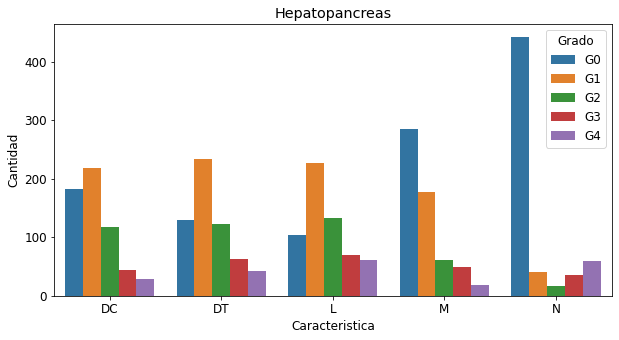

No hay imágenes en la carpeta img/Intestino
No hay imágenes en la carpeta img/Uropodo


In [5]:
for organo in organos: 
    data = count[count["Organo"] == organo]
    if data["Cantidad"].sum() != 0:
        hepato=data
        plt.figure(figsize=(10,5))
        sns.barplot(data = data, x = "Caracteristica", y = "Cantidad", hue = "Grado")
        plt.title(f"{organo}", )
        plt.show()
    else:
        print(f"No hay imágenes en la carpeta {path['img'][organo]}")

No hay imágenes en la carpeta img/AmpollaRectal
No hay imágenes en la carpeta img/Branquias


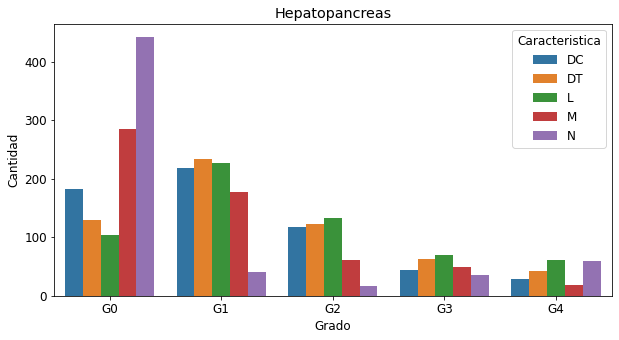

No hay imágenes en la carpeta img/Intestino
No hay imágenes en la carpeta img/Uropodo


In [6]:
for organo in organos: 
    data = count[count["Organo"] == organo]
    if data["Cantidad"].sum() != 0:
        plt.figure(figsize=(10,5))
        sns.barplot(data = data, x = "Grado", y = "Cantidad", hue = "Caracteristica")
        plt.title(f"{organo}", )
        plt.show()
    else:
        print(f"No hay imágenes en la carpeta {path['img'][organo]}")


<a name='model'></a> 
## Class weight for imbalanced datasets

In [7]:
pos_weight= {}
weight = {}
for organo in organos:
    total_img = len(get_image_files(path["img"][organo]))
    pos_count = count[count["Organo"] == organo]["Cantidad"]
    pos_weight[organo] = (total_img - pos_count)/pos_count
    weight[organo] = (total_img)/pos_count

In [8]:
# pos_weight["Hepatopancreas"].values

In [9]:
# weight["Hepatopancreas"].values

In [10]:
# ### Crear weights_max para weights
# hepato_count=count.loc[(count["Organo"] == "Hepatopancreas")]["Cantidad"]
# total_imgcount=len(get_image_files(path["img"][organo]))
# class_weights=[]
# for i in range(0, hepato_count.shape[0]):
#     class_weights.append(total_imgcount/ hepato_count.iloc[i]))
# # Important: Convert Weights To Float Tensor
# class_weights=torch.FloatTensor(class_weights).cuda()
# class_weights

In [11]:
# ### Crear weights para posweights
# hepato_count=count.loc[(count["Organo"] == "Hepatopancreas")]["Cantidad"]
# total_imgcount=len(get_image_files(path["img"][organo]))
# class_weights=[]
# for i in range(0, hepato_count.shape[0]):
#     class_weights.append((total_imgcount-hepato_count.iloc[i])/ hepato_count.iloc[i])
# # Important: Convert Weights To Float Tensor
# class_weights=torch.FloatTensor(class_weights).cuda()
# class_weights

In [12]:
# ### Crear weights para weights
# hepato_count=count.loc[(count["Organo"] == "Hepatopancreas")]["Cantidad"]
# total_imgcount=len(get_image_files(path["img"][organo]))
# class_weights=[]
# for i in range(0, hepato_count.shape[0]):
#     class_weights.append(total_imgcount/ (hepato_count.shape[0]/5 * hepato_count.iloc[i]))
    
# # Important: Convert Weights To Float Tensor
# class_weights=torch.FloatTensor(class_weights).cuda()
# class_weights

<a name='meta'></a>
## Metada

In [13]:
#Por el momento vamos a utilizar solo el órgano Hepatopancreas
organo = "Hepatopancreas"

In [14]:
metadata = get_metadata(path = path["img"][organo], organo = organo, organo_len = organo_len)
metadata.to_csv(path_or_buf = path["metadata"][organo], index=False)
metadata

,img_name,labels
0,DT_G3-DC_G0-L_G4-M_G0-N_G0.png,DT_G3 DC_G0 L_G4 M_G0 N_G0
1,DT_G2-DC_G0-L_G2-M_G1-N_G1 (2).png,DT_G2 DC_G0 L_G2 M_G1 N_G1
2,DT_G4-DC_G2-L_G4-M_G3-N_G4 (7).png,DT_G4 DC_G2 L_G4 M_G3 N_G4
3,DT_G1-DC_G4-L_G2-M_G4-N_G1 (2).png,DT_G1 DC_G4 L_G2 M_G4 N_G1
4,DT_G1-DC_G0-L_G1-M_G0-N_G0 (13).png,DT_G1 DC_G0 L_G1 M_G0 N_G0
...,...,...
587,DT_G0-DC_G1-L_G3-M_G0-N_G2.png,DT_G0 DC_G1 L_G3 M_G0 N_G2
588,DT_G0-DC_G0-L_G1-M_G0-N_G0 (9).png,DT_G0 DC_G0 L_G1 M_G0 N_G0
589,DT_G2-DC_G1-L_G3-M_G2-N_G3.png,DT_G2 DC_G1 L_G3 M_G2 N_G3
590,DT_G1-DC_G2-L_G1-M_G2-N_G0 (2).png,DT_G1 DC_G2 L_G1 M_G2 N_G0


<a name='db'></a> 
## Fijar Directorio

In [15]:
## Directorio de imagenes hepatopancreas
image_paths = sorted(glob.glob("//home/ubuntu/ATSIA/img/Hepatopancreas/*.png"))
images= []
DT=[]
DC=[]
L=[]
M=[]
N=[]
for path in image_paths:
    label = path[39:]
    images.append(path)
    DT.append(int(label[4]))
    DC.append(int(label[10]))
    L.append(int(label[15]))
    M.append(int(label[20]))
    N.append(int(label[25]))


<a name='db'></a> 
## Librerias

In [16]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import *


<a name='db'></a> 
## Crear Clase Dataset

In [17]:
class MultiTaskDataset(Dataset):
    def __init__(self, image_paths):
        # Mean and Std for ImageNet
        mean=[0.485, 0.456, 0.406] # ImageNet
        std=[0.229, 0.224, 0.225] # ImageNet
        
        # Define the Transforms
        self.transform = transforms.Compose([transforms.Resize((500, 500)),transforms.ToTensor(), transforms.Normalize(mean, std)])

        # Set Inputs and Labels
        self.image_paths = image_paths
        self.images= []
        self.DT=[]
        self.DC=[]
        self.L=[]
        self.M=[]
        self.N=[]
        

        for path in image_paths:
            label =  path[39:]
            self.images.append(path)
            self.DT.append(int(label[4]))
            self.DC.append(int(label[10]))
            self.L.append(int(label[15]))
            self.M.append(int(label[20]))
            self.N.append(int(label[25]))

    def __len__(self): return len(self.images)

    def __getitem__(self,idx):
        # Load an Image
        img = Image.open(self.images[idx]).convert('RGB')
        # Transform it
        img = self.transform(img)

        #dealing with the labels
        DT = self.DT[idx]
        DC = self.DC[idx]
        L = self.L[idx]
        M = self.M[idx]
        N = self.N[idx]
        sample = {'image':img, 'DC': DC, 'DT': DT,'L': L, 'M': M, 'N': N}
        return sample

<a name='db'></a> 
## Procesar Datos

In [18]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2

num_train = round(TRAIN_SPLIT*len(image_paths))
num_val = round(VAL_SPLIT*len(image_paths))

print('No of train samples', num_train)
print('No of validation Samples', num_val)

No of train samples 474
No of validation Samples 118


In [20]:
(train_dataset, valid_dataset) = random_split(image_paths,[num_train, num_val],generator=torch.Generator().manual_seed(42))

In [21]:
BATCH_SIZE = 4
train_dataloader = DataLoader(MultiTaskDataset(train_dataset), shuffle=False, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(MultiTaskDataset(valid_dataset), shuffle=False, batch_size=BATCH_SIZE)

train_steps = len(train_dataloader.dataset) // BATCH_SIZE
val_steps = len(val_dataloader.dataset) // BATCH_SIZE

train_steps,val_steps

(118, 29)

In [22]:
def imshow(img):
    # Unnormalize
    img = img / 2 + 0.5
	# convert to Numpy
    npimg = img.numpy()
	# Transpose to get the correct color
    npimg=np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


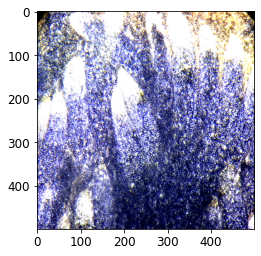

In [23]:
sample = next(iter(train_dataloader))
imshow(sample["image"][0])
plt.show()

<a name='db'></a> 
## Entrenamiento con Pytorch

In [24]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, resnet101, resnet18, resnet34
from collections import OrderedDict

In [25]:
class ATSIANET(nn.Module):
    def __init__(self, net):
        super(ATSIANET, self).__init__()
        self.net = net
        self.n_features = self.net.fc.in_features
        self.net.fc = nn.Identity()
        self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 5))]))
        self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 5))]))
        self.net.fc3 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 5))]))
        self.net.fc4 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 5))]))
        self.net.fc5 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 5))]))
 
    def forward(self, x):
        DC_head = self.net.fc1(self.net(x))
        DT_head = self.net.fc2(self.net(x))
        L_head = self.net.fc3(self.net(x))
        M_head = self.net.fc4(self.net(x))
        N_head = self.net.fc5(self.net(x))
        return DC_head, DT_head, L_head, M_head, N_head

In [26]:
net = resnet50(pretrained=True)
model = ATSIANET(net)
model.to(device=device)

DC_loss = nn.CrossEntropyLoss() # Includes Softmax
DT_loss = nn.CrossEntropyLoss() # Includes Softmax
L_loss = nn.CrossEntropyLoss() # Includes Softmax
M_loss = nn.CrossEntropyLoss() # Includes Softmax
N_loss = nn.CrossEntropyLoss() # Includes Softmax

lr = 1e-3
momentum = 0.09 # Meaning that we will go 9% with the previous direction
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [27]:
from sklearn.metrics import mean_absolute_error as mae

n_epochs = 100

logger = {"train_loss": list(),
          "validation_loss": list(),
          "train_DC_loss": list(),
          "train_DT_loss": list(),
          "train_L_loss": list(),
          "train_M_loss": list(),
          "train_N_loss": list(),
          "validation_DC_loss": list(),
          "validation_DT_loss": list(),
          "validation_L_loss": list(),
          "validation_M_loss": list(),
          "validation_N_loss": list(),
          "accuracy_DC_loss": list(),
          "accuracy_DT_loss": list(),
          "accuracy_L_loss": list(),
          "accuracy_M_loss": list(),
          "accuracy_N_loss": list(),
          }

In [28]:
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm (range(n_epochs)):
    model.train()

    total_training_loss = 0
    total_validation_loss = 0
    training_DC_loss = 0
    training_DT_loss = 0
    training_L_loss = 0
    training_M_loss = 0
    training_N_loss = 0
    validation_DC_loss = 0
    validation_DT_loss = 0
    validation_L_loss = 0
    validation_M_loss = 0
    validation_N_loss = 0
    acc_DC=0
    acc_DT=0
    acc_L=0
    acc_M=0
    acc_N=0
    
    for i, data in enumerate(train_dataloader):
        inputs = data["image"].to(device=device)
        DC_label = data["DC"].to(device=device)
        DT_label = data["DT"].to(device=device)
        L_label = data["L"].to(device=device)
        M_label = data["M"].to(device=device)
        N_label = data["N"].to(device=device)
        
        DC_output, DT_output, L_output, M_output, N_output = model(inputs)
        
        loss_1 = DC_loss(DC_output, DC_label)
        loss_2 = DT_loss(DT_output, DT_label)
        loss_3 = L_loss(L_output, L_label)
        loss_4 = M_loss(M_output, M_label)
        loss_5 = N_loss(N_output, N_label)
         
        loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5
            
        loss.backward()
                      
        if (i + 2) % 2 == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        total_training_loss += loss
        
        training_DC_loss += loss_1.item()
        training_DT_loss += loss_2.item()
        training_L_loss += loss_3.item()
        training_M_loss += loss_4.item()
        training_N_loss += loss_5.item()
            
    #print('EPOCH ', epoch+1)
   

    with torch.no_grad():
        model.eval()

        for i, data in enumerate(val_dataloader):
            inputs = data["image"].to(device=device)
            DC_label = data["DC"].to(device=device)
            DT_label = data["DT"].to(device=device)
            L_label = data["L"].to(device=device)
            M_label = data["M"].to(device=device)
            N_label = data["N"].to(device=device)
        
            
            DC_output, DT_output, L_output, M_output, N_output = model(inputs)
            loss_1 = DC_loss(DC_output, DC_label)
            loss_2 = DT_loss(DT_output, DT_label)
            loss_3 = L_loss(L_output, L_label)
            loss_4 = M_loss(M_output, M_label)
            loss_5 = N_loss(N_output, N_label)
            
            loss = loss_1 + loss_2+ loss_3+ loss_4+ loss_5
            
            total_validation_loss += loss

            validation_DC_loss += loss_1.item()
            validation_DT_loss += loss_2.item()
            validation_L_loss += loss_3.item()
            validation_M_loss += loss_4.item()
            validation_N_loss += loss_5.item()
        
            
            #print(DC_output.shape)
            out_DC = torch.argmax(F.softmax(DC_output, dim=1),axis=1)
            acc_DC += (out_DC == DC_label).sum() / DC_output.shape[0]
            out_DT = torch.argmax(F.softmax(DT_output, dim=1),axis=1)
            acc_DT += (out_DT == DT_label).sum() / DT_output.shape[0]
            out_L = torch.argmax(F.softmax(L_output, dim=1),axis=1)
            acc_L += (out_L == L_label).sum() / L_output.shape[0]
            out_M = torch.argmax(F.softmax(M_output, dim=1),axis=1)
            acc_M += (out_M == M_label).sum() / M_output.shape[0]
            out_N = torch.argmax(F.softmax(N_output, dim=1),axis=1)
            acc_N += (out_N == N_label).sum() / N_output.shape[0]
            #print(out_DT)
            #print(DT_label)
    print("[INFO] EPOCH: {}/{}".format(e + 1, n_epochs))        
    print("Training Losses: DC: {}, DT: {}, L: {}, M: {}, N: {}".format(loss_1, loss_2, loss_3, loss_4, loss_5))
    print("Validation Losses: DC: {}, DT: {}, L: {}, M: {}, N: {}".format(loss_1, loss_2, loss_3, loss_4, loss_5))
        
    avgDCAcc= acc_DC/ (val_steps+1)
    avgDTAcc= acc_DT/ (val_steps+1)
    avgLAcc= acc_L/ (val_steps+1)
    avgMAcc= acc_M/ (val_steps+1)
    avgNAcc= acc_N/ (val_steps+1)
    
    avgTrainLoss = total_training_loss / train_steps
    
    avgValLoss = total_validation_loss / val_steps
    
    print('Average Losses — Training: {} | Validation {}'.format(avgTrainLoss, avgValLoss))
    print('Accuracy — DC: {} | DT: {} | L: {} | M: {} | N: {}'.format(avgDCAcc, avgDTAcc, avgLAcc, avgMAcc, avgNAcc))
    print() 
    avgTrainDCLoss = training_DC_loss/len(train_dataloader.dataset)
    avgTrainDTLoss = training_DT_loss/len(train_dataloader.dataset)

    avgValDCLoss = validation_DC_loss/len(val_dataloader.dataset)
    avgValDTLoss = validation_DT_loss/len(val_dataloader.dataset)

    logger["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    logger["train_DC_loss"].append(avgTrainDCLoss)
    logger["train_DT_loss"].append(avgTrainDTLoss)
    logger["train_L_loss"].append(avgTrainDTLoss)
    logger["train_M_loss"].append(avgTrainDTLoss)
    logger["train_N_loss"].append(avgTrainDTLoss)
    
    logger["validation_loss"].append(avgValLoss.cpu().detach().numpy())
    logger["validation_DC_loss"].append(avgValDCLoss)
    logger["validation_DT_loss"].append(avgValDTLoss)
    logger["validation_L_loss"].append(avgValDTLoss)
    logger["validation_M_loss"].append(avgValDTLoss)
    logger["validation_N_loss"].append(avgValDTLoss)
    
    logger["accuracy_DC_loss"].append(avgDCAcc)
    logger["accuracy_DT_loss"].append(avgDTAcc)
    logger["accuracy_L_loss"].append(avgLAcc)
    logger["accuracy_M_loss"].append(avgMAcc)
    logger["accuracy_N_loss"].append(avgNAcc)
    
    

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

[INFO] training the network...


  0%|                                                                                           | 0/100 [01:33<?, ?it/s]


KeyboardInterrupt: 

<a name='db'></a> 
## Entrenamiento con Fastai

In [9]:
#hide
from fastbook import *
from IPython.display import display,HTML
from fastai.vision.widgets import *

In [10]:
#Obtener Imagenes
PATH = "//home/ubuntu/ATSIA/img/Hepatopancreas"
files = get_image_files(str(PATH))
len(files)


592

In [11]:
l2i ={ "DC_G0":0, "DC_G1":1, "DC_G2":2, "DC_G3":3, "DC_G4":4,"DT_G0":5, "DT_G1":6, "DT_G2":7, "DT_G3":8, "DT_G4":9,"L_G0":10, "L_G1":11, "L_G2":12, "L_G3":13, "L_G4":14,"M_G0":15, "M_G1":16, "M_G2":17, "M_G3":18, "M_G4":19,"N_G0":20, "N_G1":21, "N_G2":22, "N_G3":23, "N_G4":24}
i2l = { 0: "DC_G0", 1:"DC_G1", 2: "DC_G2", 3:"DC_G3", 4:"DC_G4",5:"DT_G0", 6:"DT_G1", 7:"DT_G2", 8:"DT_G3", 9:"DT_G4",10:"L_G0", 11:"L_G1", 12:"L_G2", 13:"L_G3", 14:"L_G4",15:"M_G0", 16:"M_G1", 17: "M_G2", 18:"M_G3", 19:"M_G4", 20:"N_G0", 21:"N_G1", 22:"N_G2", 23:"N_G3", 24:"N_G4"}

In [12]:
class MultiOutputCategorize(DisplayedTransform):
    def __init__(self, l2i=l2i, i2l=i2l):
        self.l2i = l2i
        self.i2l = i2l

    def encodes(self, string_label):
        #print(string_label)
        return TensorCategory([self.l2i[l] for l in string_label])

    def decodes(self, encoded_label):
        #print(encoded_label)
        return Category([self.i2l[v.item()] for v in encoded_label])

In [13]:
multi=MultiOutputCategorize(l2i, i2l)
multi.encodes([files[0].stem[0:5],files[0].stem[6:11],files[0].stem[12:16],files[0].stem[17:21],files[0].stem[22:]])

TensorCategory([ 8,  0, 14, 15, 20])

In [14]:
multi.decodes(TensorCategory([ 8,  0, 14, 15, 20]))

"['DT_G3', 'DC_G0', 'L_G4', 'M_G0', 'N_G0']"

In [15]:
from torch.utils.data import Dataset
from torchvision import transforms
from fastai.vision import *

In [16]:
# Crear Datablock
dblock = DataBlock(blocks=(ImageBlock,TransformBlock(type_tfms=MultiOutputCategorize())),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42), 
                   get_y= lambda x: [x.stem[0:5],x.stem[6:11],x.stem[12:16],x.stem[17:21],x.stem[22:26]],
                   item_tfms = Resize(500,method= "crop", pad_mode= "zeros"),
                   batch_tfms = Normalize.from_stats(*imagenet_stats))#RandomResizedCrop(400, min_scale=0.35)


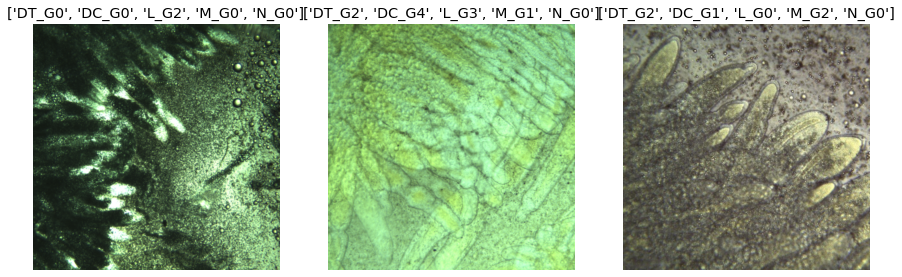

In [17]:
#Crear data loader y batch size =32
dls = dblock.dataloaders(files, bs=8)
dls = dls.cuda()
# Mostrar dataset aplicado modificaciones
dls.show_batch(nrows=1, ncols=3, figsize=(15,10))

In [18]:
b = dls.one_batch()
b[1][1]

TensorCategory([ 7,  2, 11, 15, 20], device='cuda:0')

In [34]:
N_OUTPUTS = 5
N_CLASSES= 25
class ReshapeLayer(nn.Module):
    def __init__(self, n_classes=N_CLASSES, n_outputs=N_OUTPUTS):
        super().__init__()
        self.n_classes = n_classes
        self.n_outputs = n_outputs
    
    def forward(self, out):
        out = out.reshape(-1, self.n_classes, self.n_outputs)

        return out

In [35]:
body = create_body(resnet101, cut=-2,pretrained=True)

head = create_head(4*body[-1][-1].bn2.num_features, N_OUTPUTS * N_CLASSES, ps=0.25)

In [36]:
body[-1][-1].bn2.num_features

512

In [37]:
model = nn.Sequential(
    body,
    head,
    ReshapeLayer(n_classes=N_CLASSES, n_outputs=N_OUTPUTS),
    # output will be [bs, num_classes=25, n_outputs=]
)
model = model.cuda()

In [38]:
def model_splitter(model):
    return [params(model[0]), params(model[1:])]

In [39]:
def multi_output_accuracy(inp, targ):
    labels_pred = torch.softmax(inp, dim=1)
    labels_pred = torch.argmax(labels_pred, dim=1)

    return ((labels_pred == targ).all(dim=1)).sum() / inp.size(0)
def multi_output_individual_accuracy(inp, targ):
    labels_pred = torch.softmax(inp, dim=1)
    labels_pred = torch.argmax(labels_pred, dim=1)
    return (labels_pred == targ).sum() / (inp.size(0) * targ.size(1))

In [40]:
class MultiOutputCrossEntropyLoss(CrossEntropyLossFlat):
    def __init__(self, *args, **kwargs):
        super().__init__(flatten=False, reduction="sum", axis=1, *args, **kwargs)
    
    def __call__(self, inp, targ, **kwargs):
        # fastai does an extra transpose inside, but we do need it, so this reverses it
        inp = inp.transpose(1, 2)
        return super().__call__(inp, targ, **kwargs)

In [45]:
 ### Crear weights_max para weights
organo="Hepatopancreas"
hepato_count=count.loc[(count["Organo"] == "Hepatopancreas")]["Cantidad"]
total_imgcount=len(get_image_files(path["img"][organo]))
class_weights=[]
for i in range(0, hepato_count.shape[0]):
    class_weights.append( total_imgcount/(hepato_count.iloc[i]*25))
# # Important: Convert Weights To Float Tensor
class_weights=torch.FloatTensor(class_weights).cuda()
class_weights

tensor([0.1294, 0.1086, 0.2007, 0.5382, 0.8166, 0.1836, 0.1012, 0.1925, 0.3759, 0.5507, 0.2299, 0.1048, 0.1780, 0.3432, 0.3882, 0.0831, 0.1330, 0.3882, 0.4736, 1.3156, 0.0536, 0.5920, 1.4800, 0.6766,
        0.4014], device='cuda:0')

In [46]:
# Crear modelo
learn = Learner(dls, model, loss_func=MultiOutputCrossEntropyLoss(weight = class_weights), metrics=[multi_output_accuracy, multi_output_individual_accuracy], splitter=model_splitter)

In [80]:
learn.freeze()
learn.lr_find()

KeyboardInterrupt: 

In [47]:
learn.freeze()
learn.fit_one_cycle(10, lr_max=1e-3)

epoch,train_loss,valid_loss,multi_output_accuracy,multi_output_individual_accuracy,time
0,13.408239,15.403855,0.076271,0.562712,00:58
1,11.134761,13.200710,0.101695,0.545763,00:58
2,10.012228,12.727040,0.050847,0.494915,00:58
3,8.796297,14.449634,0.050847,0.522034,00:58
4,7.209910,13.183187,0.084746,0.528814,01:01
5,6.102472,13.443384,0.084746,0.537288,00:58
6,4.860619,13.259965,0.084746,0.523729,00:59
7,4.073997,13.747871,0.059322,0.542373,00:58
8,3.559308,13.375396,0.110169,0.549152,00:58
9,3.341179,13.800457,0.084746,0.544068,00:59


In [48]:
learn.unfreeze()
learn.fit_one_cycle(20, lr_max=slice(3e-4,2e-3))

epoch,train_loss,valid_loss,multi_output_accuracy,multi_output_individual_accuracy,time
0,3.735555,14.609147,0.110169,0.535593,01:02
1,5.060358,18.207384,0.059322,0.430508,01:04
2,9.668657,18.976885,0.050847,0.447458,01:03
3,11.946212,26.000338,0.000000,0.330508,01:04
4,12.807375,22.309027,0.008475,0.347458,01:04
5,12.557584,15.725998,0.042373,0.422034,01:03
6,12.743837,15.942319,0.008475,0.310169,01:03
7,12.422558,18.629232,0.000000,0.347458,01:03
8,12.397387,42.684116,0.000000,0.274576,01:03
9,11.800960,14.502855,0.050847,0.450847,01:02


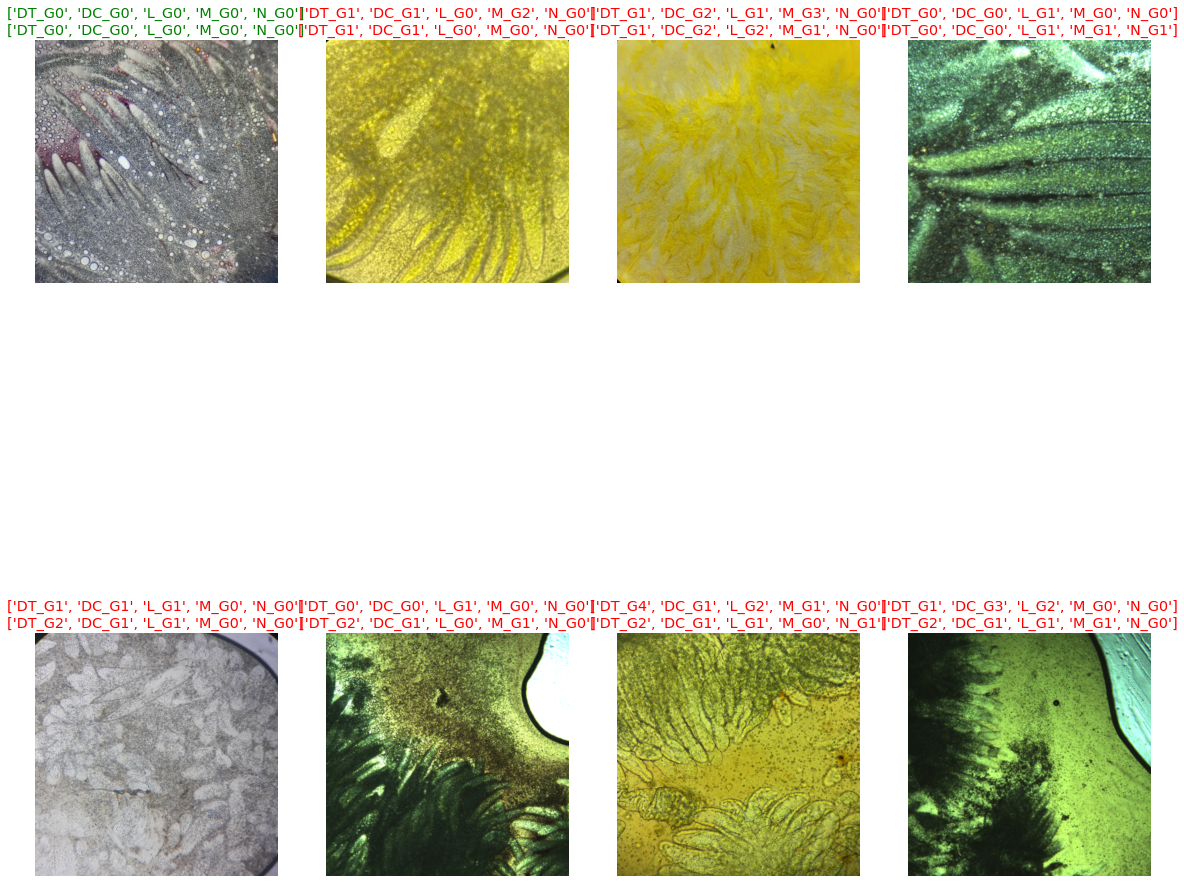

In [50]:
learn.show_results( max_n = 20, figsize = (20,20), shuffle=False)

In [51]:
preds,targs = learn.get_preds()

In [54]:
preds[0].shape

torch.Size([25, 5])